In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns

from functions.EpiIndex import *
from functions.Connectivity import *

# Reading and preprocessing

In [2]:
#raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)
raw=mne.io.read_raw_fif('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/Pat28_seizure_segment_raw.fif', preload=True)
raw.pick_types(eeg=True, bio=False, misc=False)
channels_1=raw.ch_names
##Dropping channels
##channels = raw.ch_names
##channels_to_remove=['E']
##raw.drop_channels(channels_to_remove)
#channels = raw.ch_names
##Filter
#raw.filter(l_freq = 0, h_freq = 97.0)
## Set the frequency you want to remove; it's commonly 50 Hz or 60 Hz
#notch_freq = 60  # or 60 for the USA and other countries using 60Hz
## Apply notch filter
#raw.notch_filter(freqs = notch_freq)

#For seeg signals
#Channels to drop from preprocessing inspection
channels_to_drop=['EEG 008', 'EEG 009', 'EEG 029', 'EEG 051', 'EEG 082', 'EEG 102', 'EEG 103', 'EEG 104', 'EEG 105']
#data without outlier channes   
raw.drop_channels(channels_to_drop)

Opening raw data file /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/Pat28_seizure_segment_raw.fif...
Isotrak not found
    Range : 6448128 ... 7062528 =   6297.000 ...  6897.000 secs
Ready.
Reading 0 ... 614400  =      0.000 ...   600.000 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,97 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)


/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/environment/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


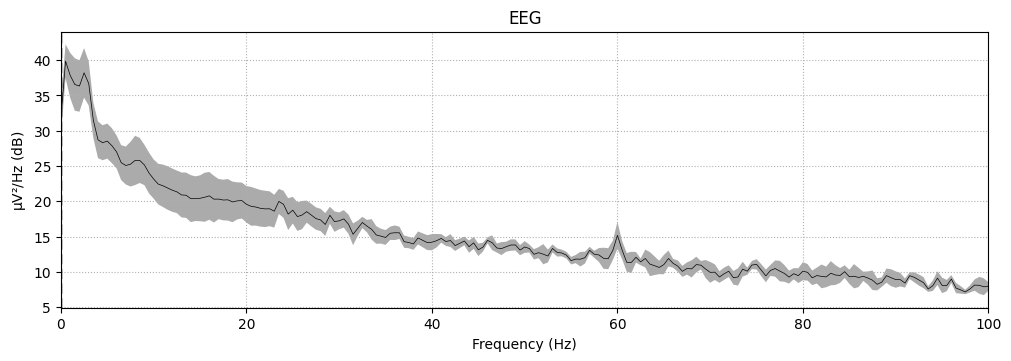

In [3]:
raw.plot_psd(fmin=0, fmax=100, average=True, spatial_colors=False)
plt.show()
channels = raw.ch_names

# Getting EI

In [4]:
#Ei_n1, ER_matrix1, U_n_matrix, ER_n_array, alarm_time = get_EI(raw)

Alarm time for channel 0 is 316460.0
Alarm time for channel 1 is 316455.0
Alarm time for channel 2 is 316426.0
Alarm time for channel 3 is 316444.0
Alarm time for channel 4 is 316541.0
Alarm time for channel 5 is 316532.0
Alarm time for channel 6 is 316514.0
Alarm time for channel 7 is 316556.0
Alarm time for channel 8 is 315958.0
Alarm time for channel 9 is 316096.0
Alarm time for channel 10 is 231475.0
Alarm time for channel 11 is 316372.0
Alarm time for channel 12 is 316395.0
Alarm time for channel 13 is 316470.0
Alarm time for channel 14 is 316490.0
Alarm time for channel 15 is 316500.0
Alarm time for channel 16 is 316530.0
Alarm time for channel 17 is 168302.0
Alarm time for channel 18 is 315724.0
Alarm time for channel 19 is 315668.0
Alarm time for channel 20 is 315652.0
Alarm time for channel 21 is 166550.0
Alarm time for channel 22 is 316361.0
Alarm time for channel 23 is 316126.0
Alarm time for channel 24 is 316410.0
Alarm time for channel 25 is 316382.0
Alarm time for channel

In [ ]:
#Ei_n2, ER_matrix2, U_n_matrix, ER_n_array, alarm_time = get_EI_optimal_lambda_vs1(raw, np.arange(0,300,50))

Calculating optimal lambda for channel  0
lambda is  0
Total alarm times are  107620
Current best lambda is  0
Current best alarm times are  294501
-------------------
lambda is  50
Total alarm times are  105580
Current best lambda is  0
Current best alarm times are  107620
-------------------
lambda is  100
Total alarm times are  105406
Current best lambda is  50
Current best alarm times are  105580
-------------------
lambda is  150
Total alarm times are  105261
Current best lambda is  100
Current best alarm times are  105406
-------------------
lambda is  200
Total alarm times are  105118
Current best lambda is  150
Current best alarm times are  105261
-------------------
lambda is  250
Total alarm times are  104946
Current best lambda is  200
Current best alarm times are  105118
-------------------
---> Optimal lambda for channel  0  is  250
-------------------
Calculating optimal lambda for channel  1
lambda is  0
Total alarm times are  105788
Current best lambda is  0
Current bes

In [ ]:
#Ei_n3, ER_matrix3, U_n_matrix, ER_n_array, alarm_time, derivates_d1_matrix, derivates_d2_matrix = get_ei_optimal_vs2(raw)

Alarm time for channel 0 is 191159.0
Alarm time for channel 1 is 210015.0
Alarm time for channel 2 is 259380.0
Alarm time for channel 3 is 255280.0
Alarm time for channel 4 is 250282.0
Alarm time for channel 5 is 250282.0
Alarm time for channel 6 is 217393.0
Alarm time for channel 7 is 222394.0
Alarm time for channel 8 is 217393.0
Alarm time for channel 9 is 217393.0
Alarm time for channel 10 is 222586.0
Alarm time for channel 11 is 258492.0
Alarm time for channel 12 is 255280.0
Alarm time for channel 13 is 217393.0
Alarm time for channel 14 is 153194.0
Alarm time for channel 15 is 152337.0
Alarm time for channel 16 is 255280.0
Alarm time for channel 17 is 258475.0
Alarm time for channel 18 is 152807.0
Alarm time for channel 19 is 152117.0
Alarm time for channel 20 is 217393.0
Alarm time for channel 21 is 259379.0


In [20]:
def plotting_ei(Ei_n, ER_matrix,channels, derivatives_d1=None):
    if derivatives_d1 is None:
        #plt.imshow(ER_matrix,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
        ##colorbar
        #plt.colorbar()
        #plt.yticks(np.arange(len(channels)), channels)
        #plt.xlabel('Window number')
        #plt.ylabel('Channel name')
        #plt.title('ER_n')
        #plt.show()

        #Plting a barplt of the EI values for every channel
        #widther figure
        plt.figure(figsize=(20,5))
        plt.bar(channels,Ei_n)
        plt.xlabel('Channel name')
        #90 degrees rotation
        plt.xticks(rotation=90)
        plt.ylabel('EI')
        plt.show()
    else:
        plt.imshow(ER_matrix,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
        #colorbar
        plt.colorbar()
        plt.yticks(np.arange(len(channels)), channels)
        plt.xlabel('Window number')
        plt.ylabel('Channel name')
        plt.title('ER_n')
        plt.show()

        #Plting a barplt of the EI values for every channel
        plt.bar(channels,Ei_n)
        plt.xlabel('Channel name')
        plt.ylabel('EI')
        plt.show()

        plt.imshow(derivatives_d1,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
        #colorbar
        plt.colorbar()
        plt.yticks(np.arange(len(channels)), channels)
        plt.xlabel('Window number')
        plt.ylabel('Channel name')
        plt.title('ER_n')
        plt.show()

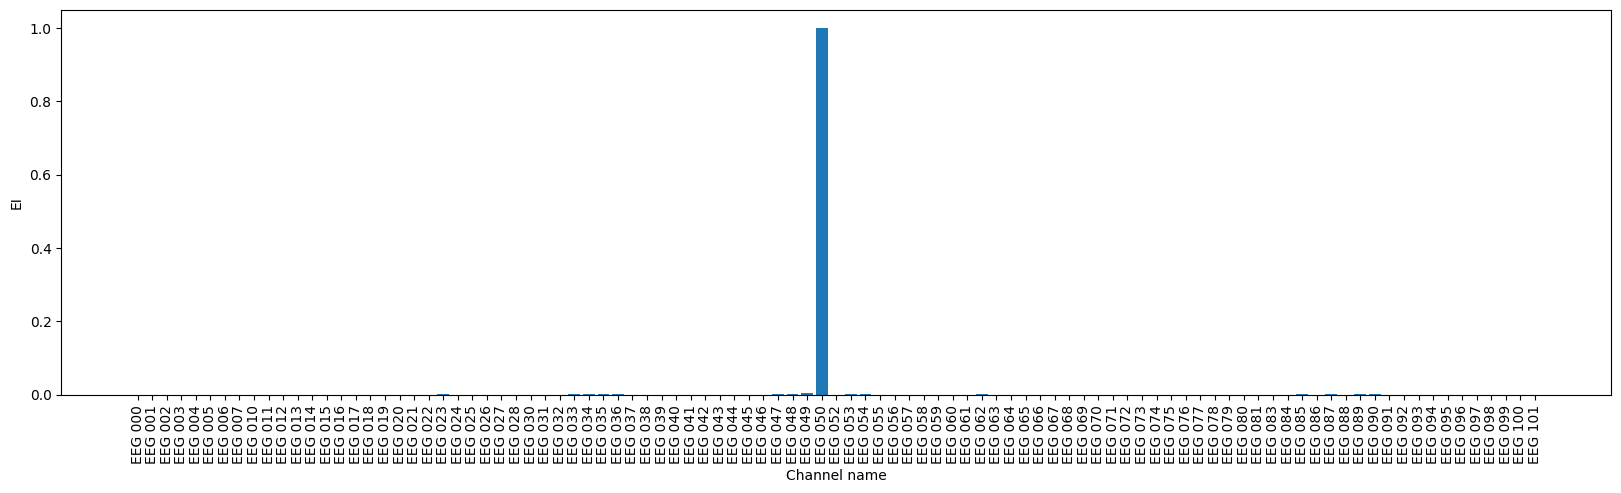

In [21]:
#plotting_ei(Ei_n1, ER_matrix1, channels)
#plotting_ei(Ei_n2, ER_matrix2, channels)
#plotting_ei(Ei_n3, ER_matrix3, channels,derivates_d1_matrix)

# Connectivity Measures

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 102400 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 4656 connections
    using t=0.000s..99.999s for estimation (102400 points)
    frequencies: 4.0Hz..9.0Hz (501 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Replacing exis

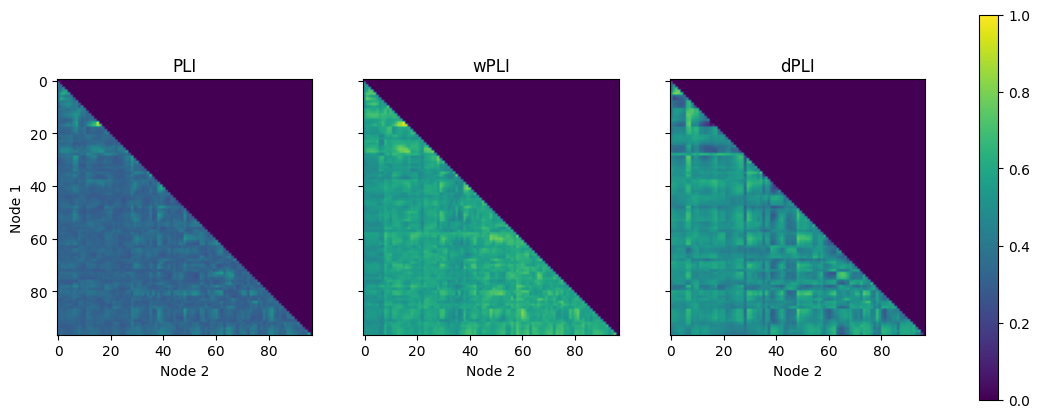

In [5]:
con_pli, con_wpli,con_dpli=compute_connectivity(raw)

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 102400 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 4656 connections
    using t=0.000s..99.999s for estimation (102400 points)
    computing connectivity for the bands:
     band 1: 8.0Hz..13.0Hz (501 points)
     band 2: 13.0Hz..30.0Hz (1701 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5


    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Frequencies in Hz over which coherence was averaged for alpha:
10.5
Frequencies in Hz over which coherence was averaged for beta:
21.5


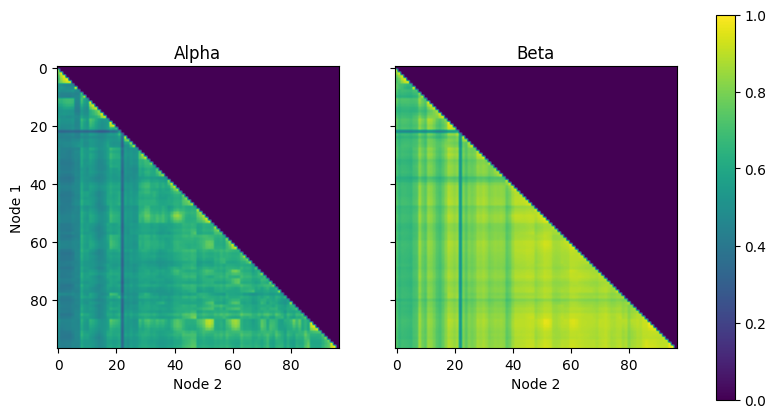

In [6]:
coh =compute_coherence(raw)

# Correlation for graph connection 

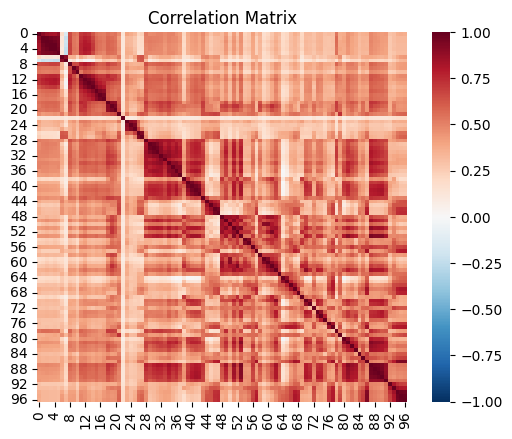

Adjacency matrix for Correlation matrix


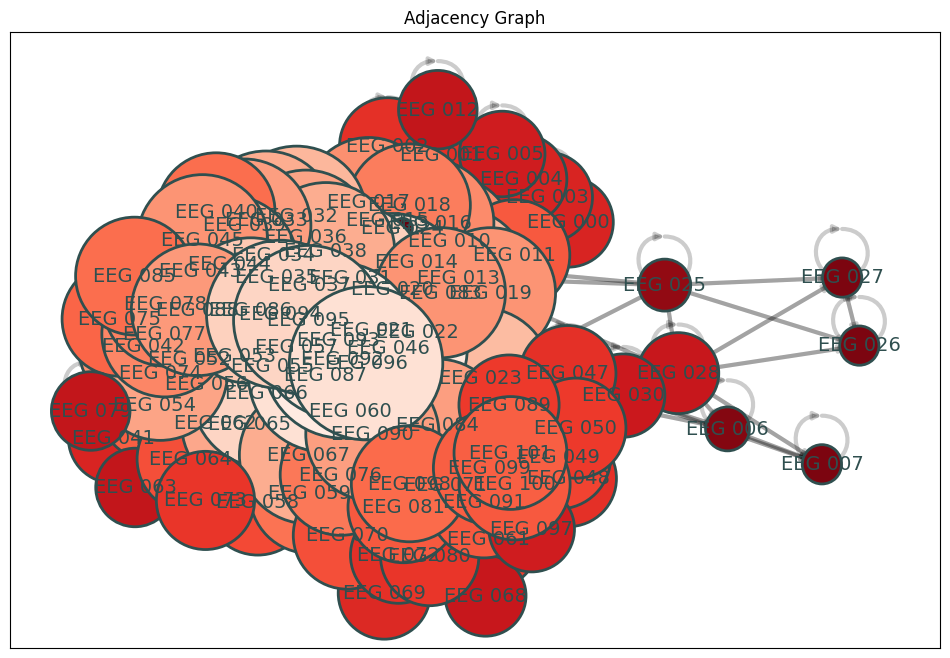

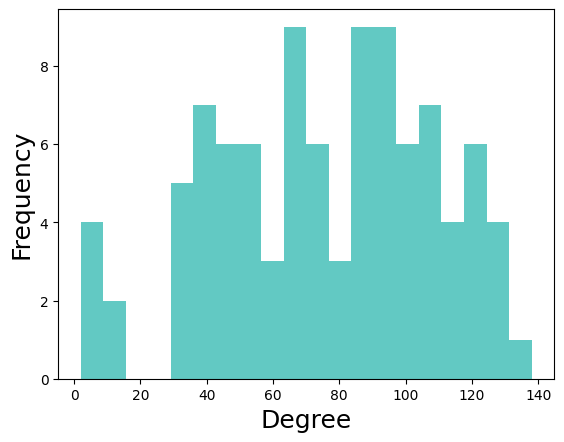

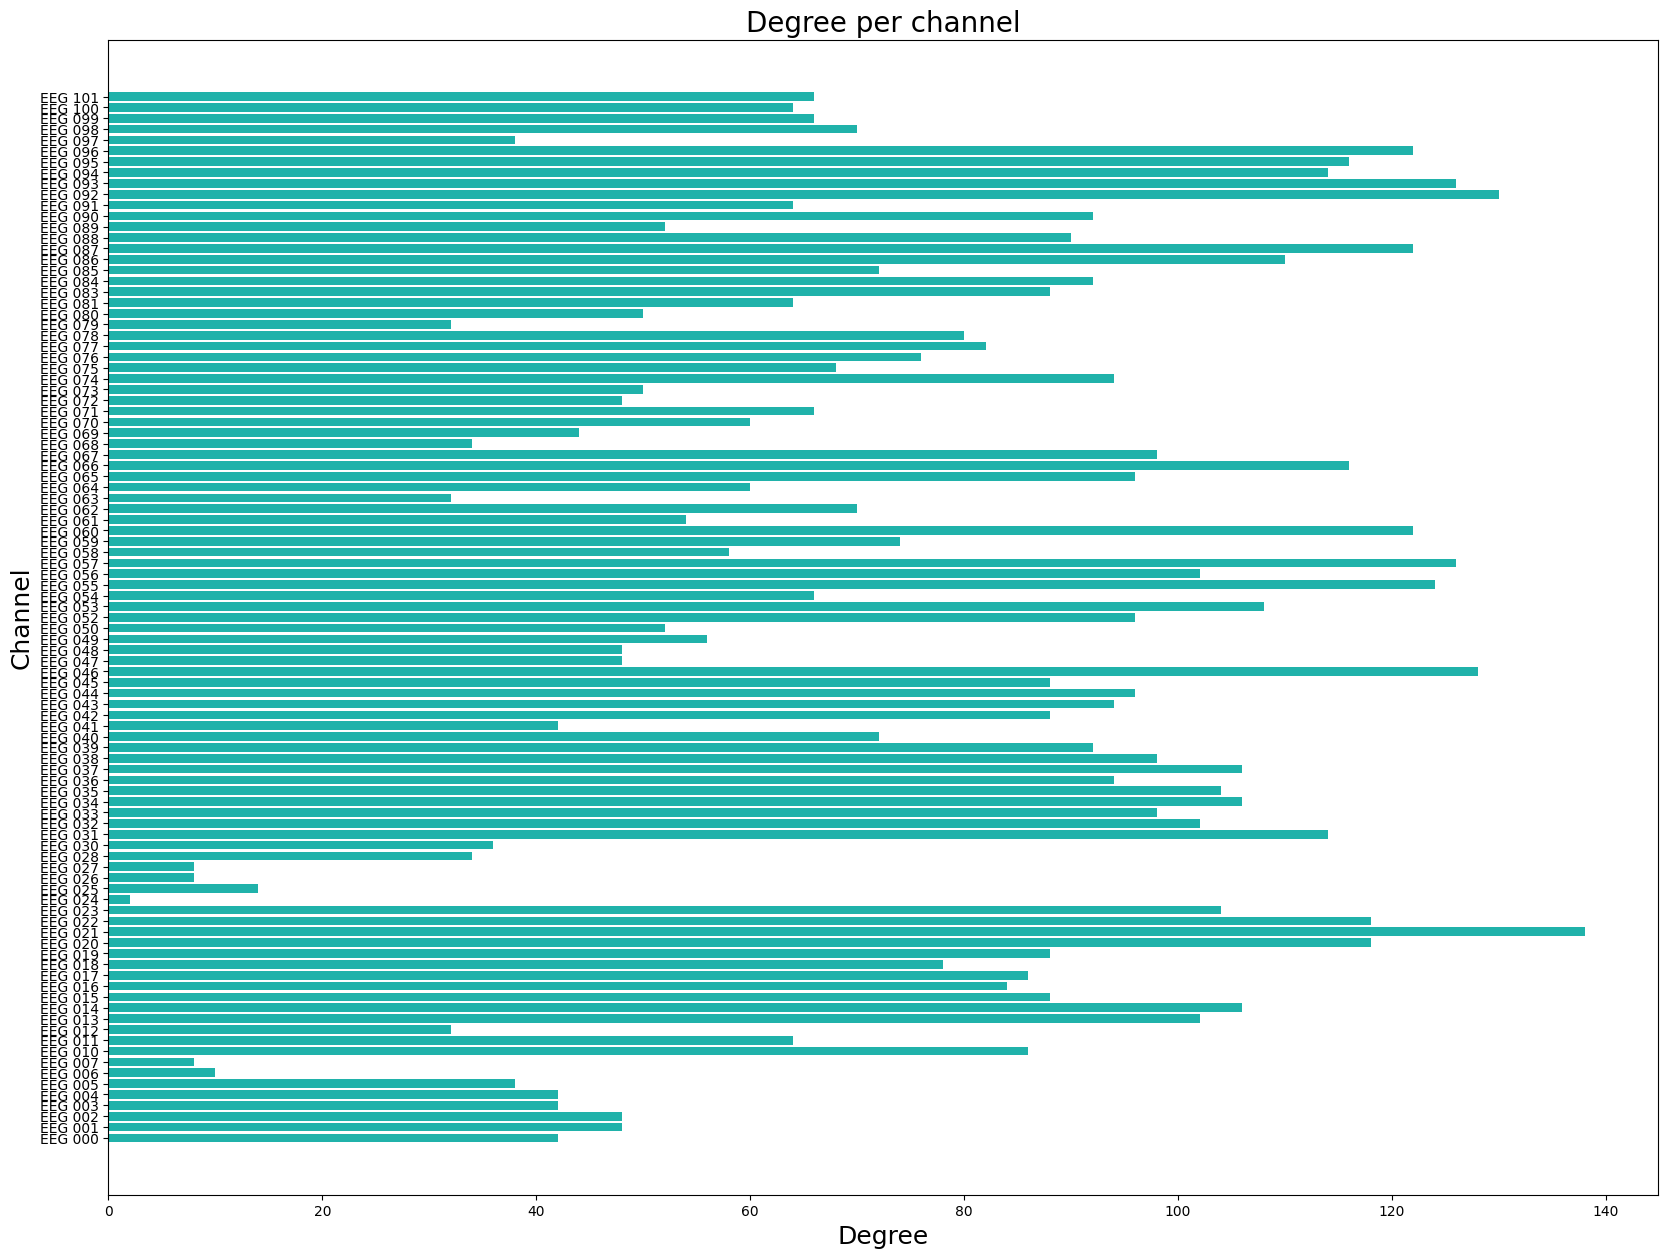

In [7]:
a_thresholded,G=compute_adjacency_graph(raw)

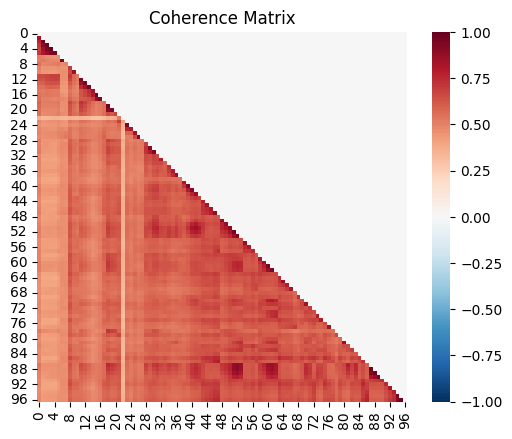

Adjacency matrix for Coherence matrix


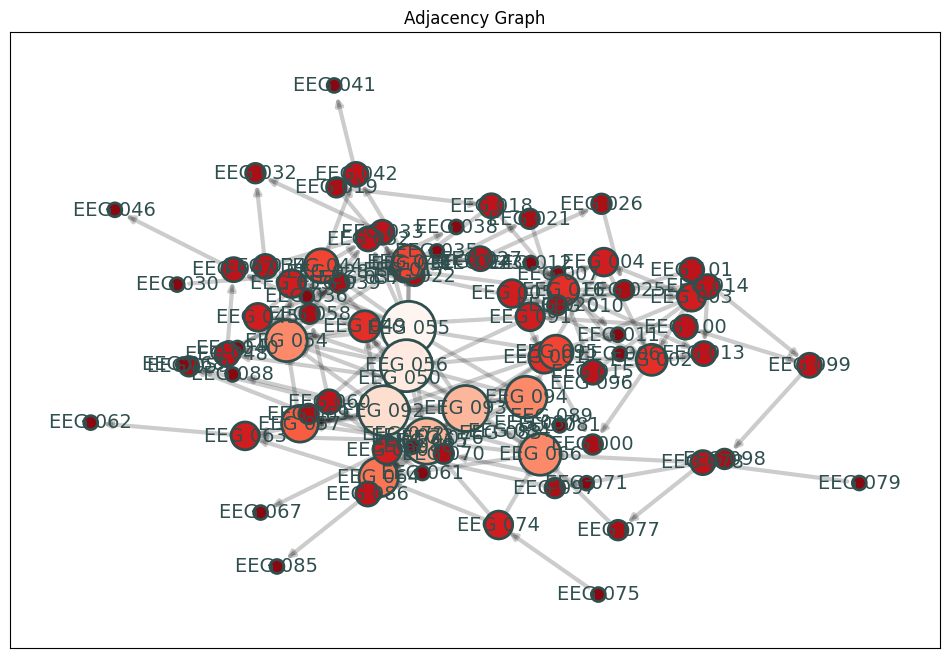

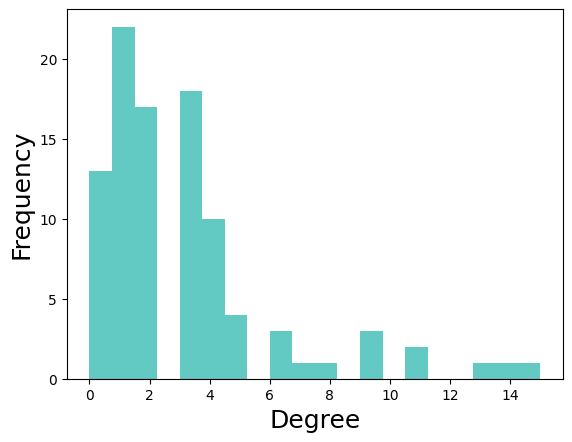

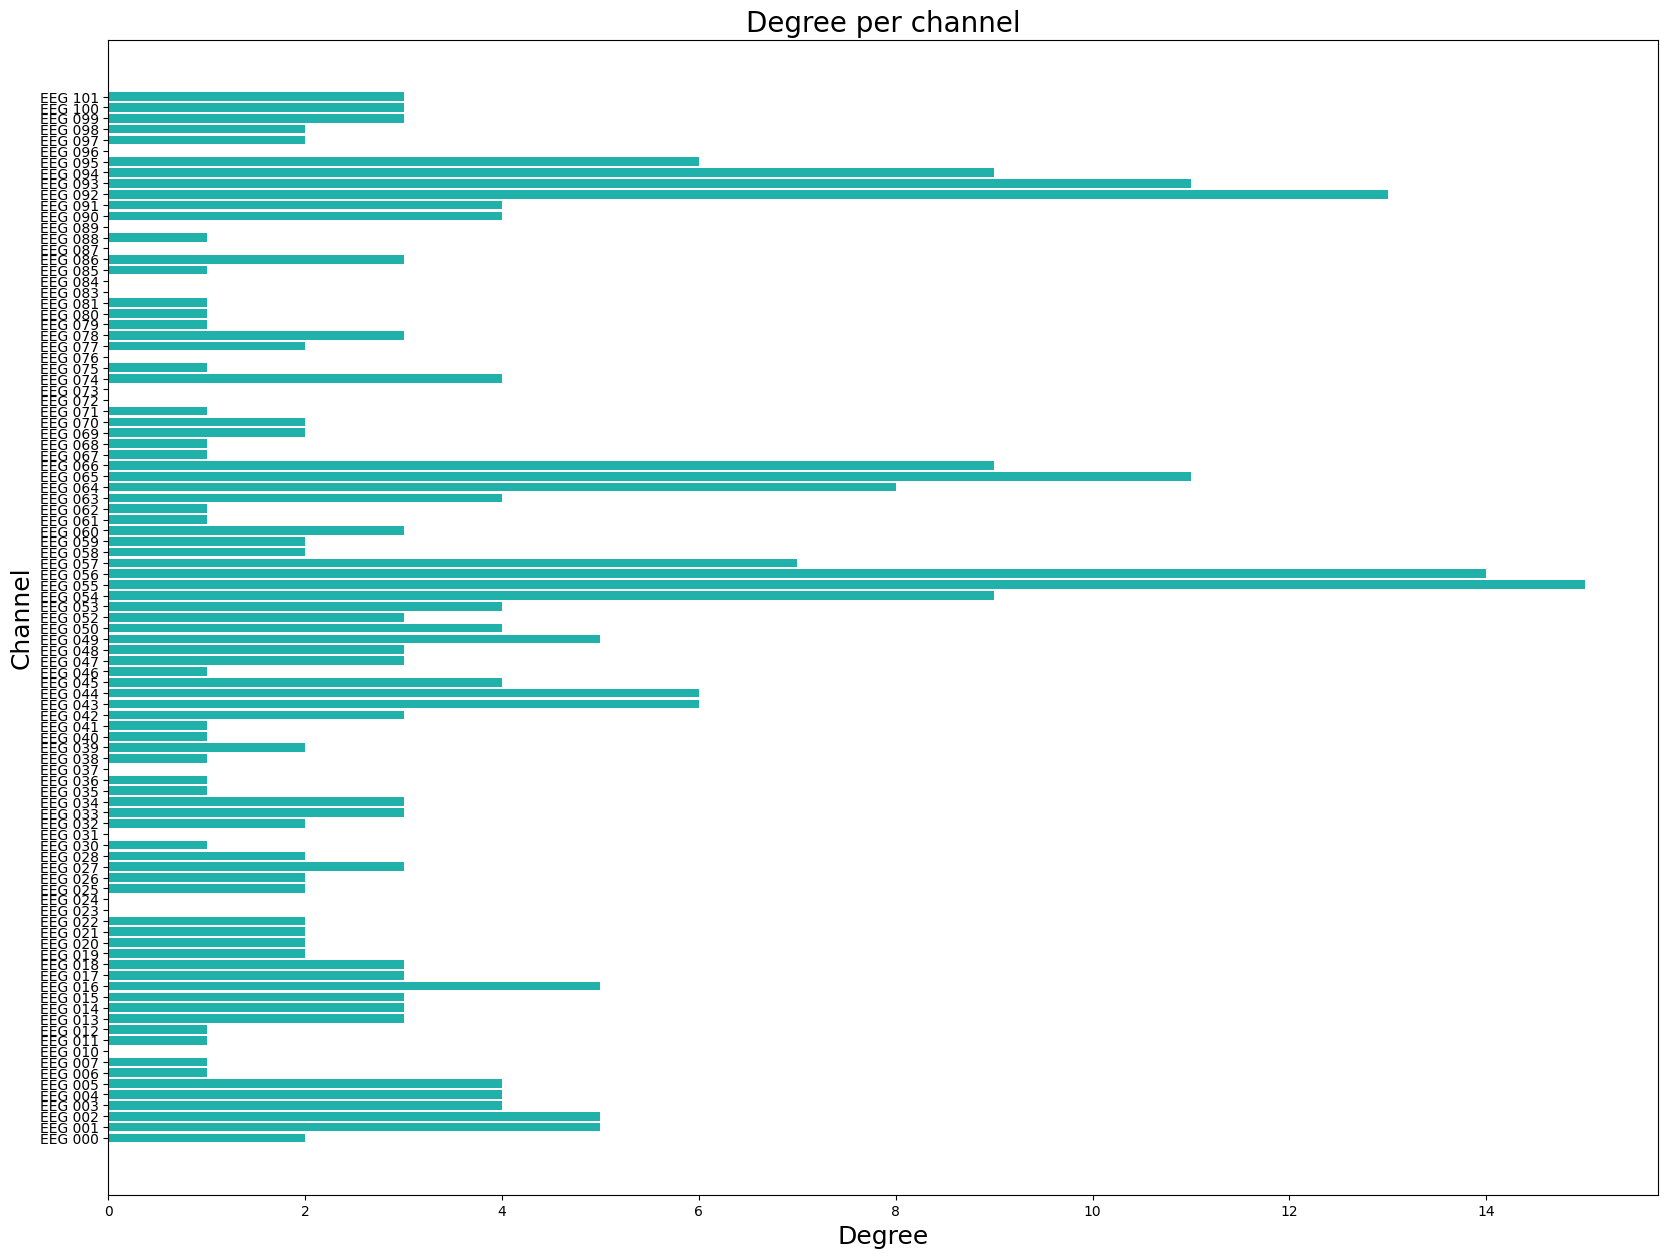

In [8]:
a_thresholded,G=compute_adjacency_graph(raw,coh[:,:,0],"Coherence",0.75)

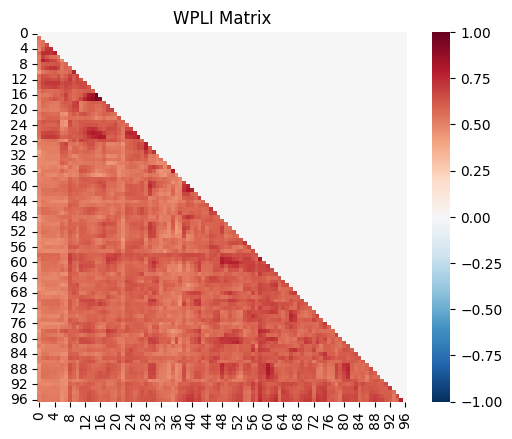

Adjacency matrix for WPLI matrix


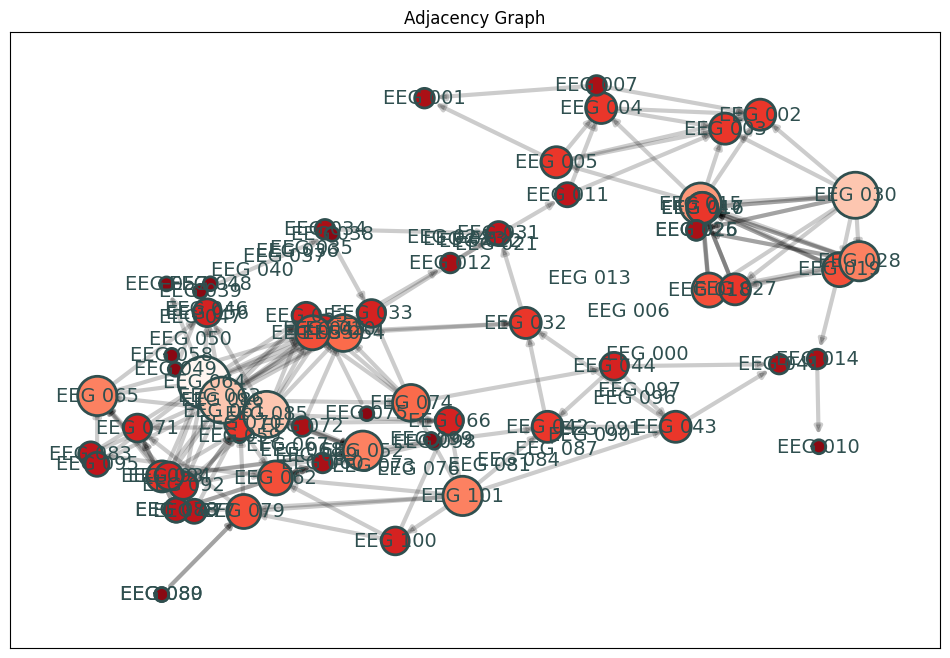

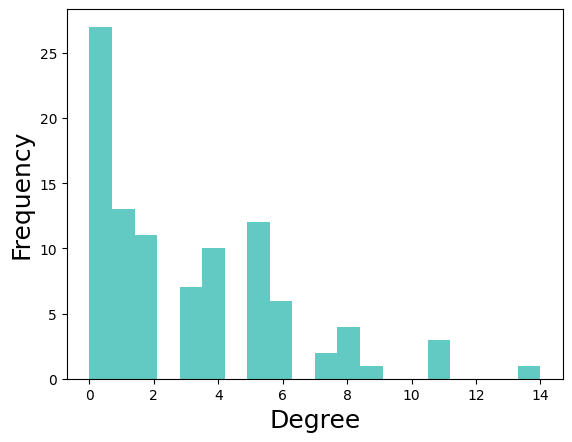

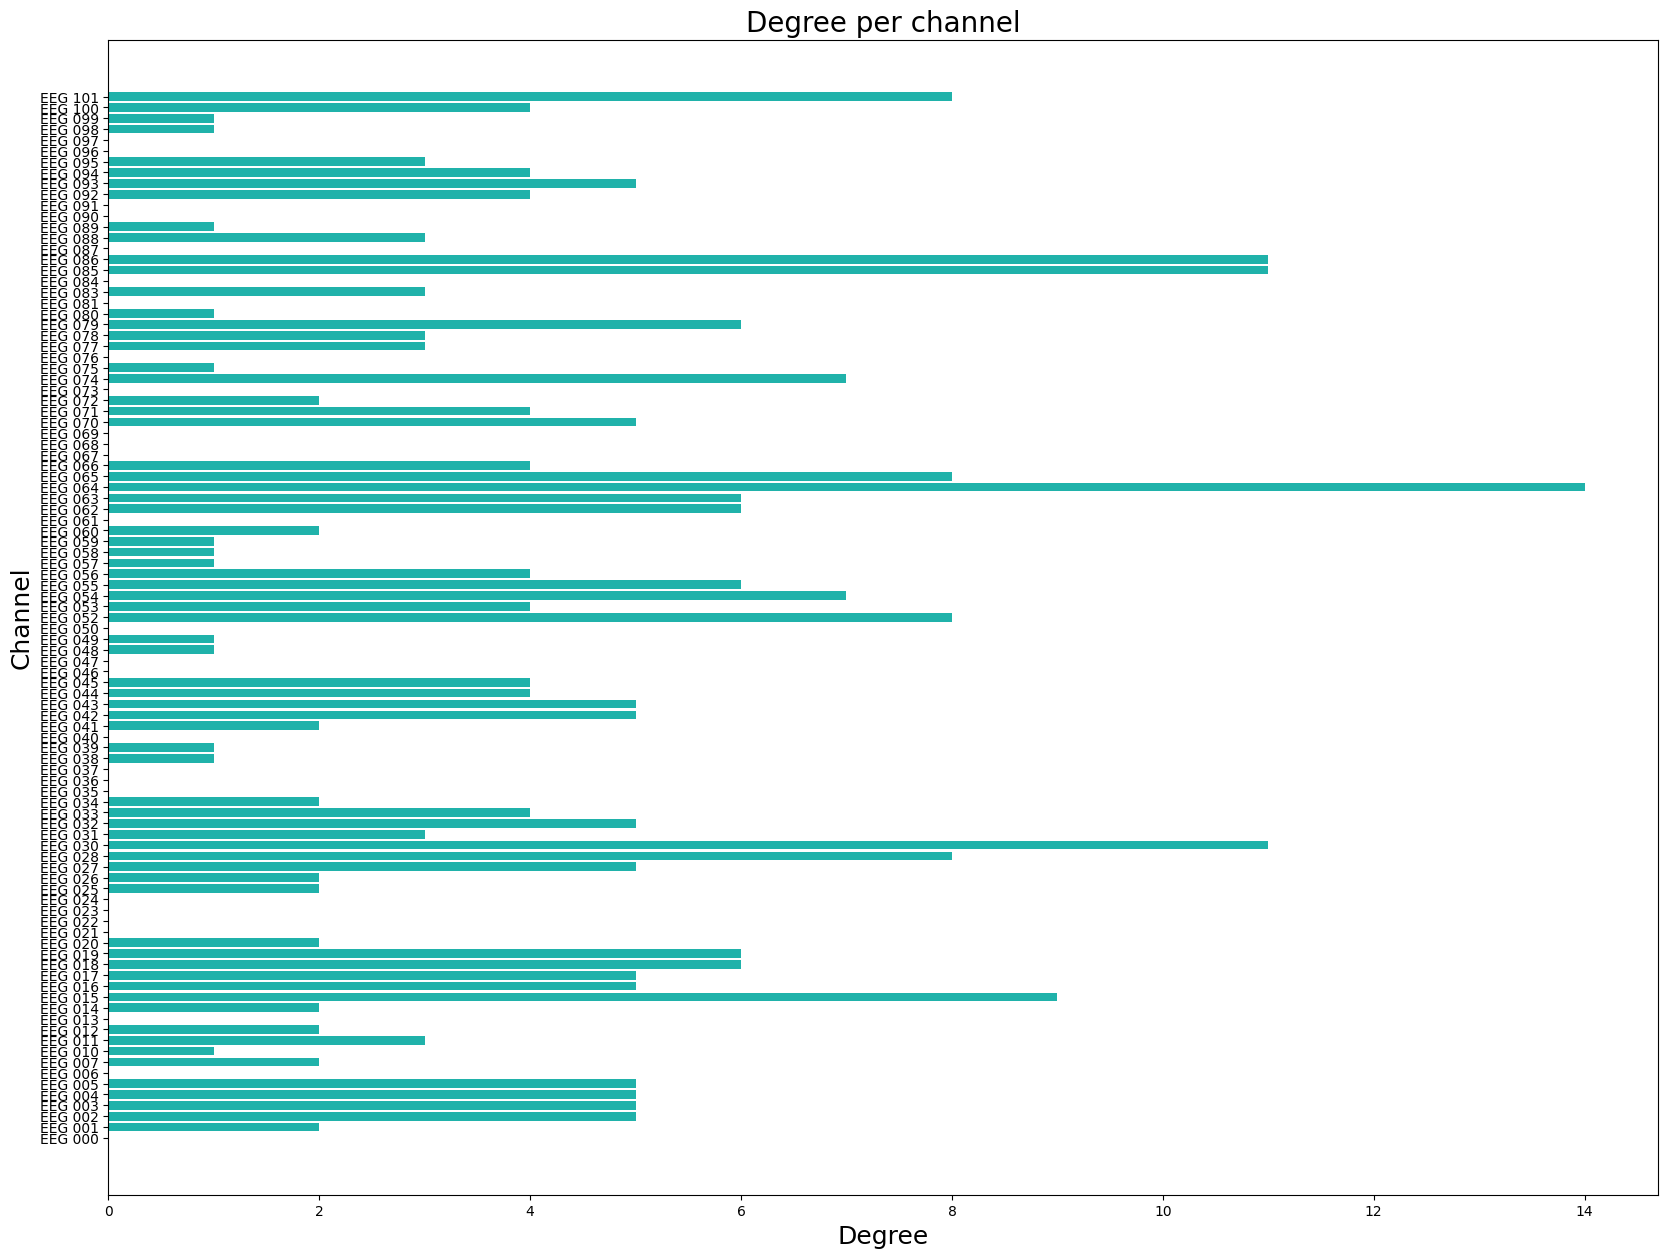

In [9]:
a_thresholded,G=compute_adjacency_graph(raw,con_wpli[:,:,0],"WPLI",0.7)